<a href="https://colab.research.google.com/github/MIT-LCP/sccm-datathon/blob/master/04_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# eICU Collaborative Research Database

# Notebook 4: Timeseries for a single patient

This notebook explores timeseries data for a single patient.


## Load libraries and connect to the database

In [0]:
# Import libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

# Make pandas dataframes prettier
from IPython.display import display, HTML

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

In [0]:
# authenticate
auth.authenticate_user()

In [0]:
# Set up environment variables
project_id='sccm-datathon'
os.environ["GOOGLE_CLOUD_PROJECT"]=project_id

## Selecting a single patient stay


### The patient table

The patient table includes general information about the patient admissions (for example, demographics, admission and discharge details). See: http://eicu-crd.mit.edu/eicutables/patient/

In [0]:
# Display the patient table
%%bigquery

SELECT *
FROM `physionet-data.eicu_crd_demo.patient`

In [36]:
patient.head()

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,...,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid
0,210014,182373,Male,45,Caucasian,73,89,"Hypertension, uncontrolled (for cerebrovascula...",178.0,13:08:59,...,Direct Admit,1,admit,116.0,112.7,15:00:00,4424,Skilled Nursing Facility,Alive,002-10665
1,200026,174624,Male,50,Caucasian,71,87,Ablation or mapping of cardiac conduction pathway,177.8,10:41:00,...,Operating Room,1,admit,106.1,106.1,17:40:00,1548,Home,Alive,002-10715
2,221131,190993,Male,83,Caucasian,71,87,"Endarterectomy, carotid",175.3,21:43:00,...,Operating Room,1,admit,NaN,72.1,17:46:00,1203,Home,Alive,002-10249
3,221215,191054,Male,49,Caucasian,71,87,"Infarction, acute myocardial (MI)",185.4,03:16:00,...,Emergency Department,1,admit,145.3,146.6,19:07:00,1562,Home,Alive,002-10627
4,217835,188445,Male,57,Caucasian,73,92,"CABG alone, coronary artery bypass grafting",172.7,01:09:00,...,Operating Room,1,admit,NaN,80.4,08:25:00,4719,Floor,Alive,002-10324


### The `vitalperiodic` table

The `vitalperiodic` table comprises data that is consistently interfaced from bedside vital signs monitors into eCareManager. Data are generally interfaced as 1 minute averages, and archived into the `vitalperiodic` table as 5 minute median values. For more detail, see: http://eicu-crd.mit.edu/eicutables/vitalPeriodic/

In [0]:
# Get periodic vital signs for a single patient stay
%%bigquery vitalperiodic

SELECT *
FROM `physionet-data.eicu_crd_demo.vitalperiodic`
WHERE patientunitstayid =  210014

In [50]:
vitalperiodic.head()

,vitalperiodicid,patientunitstayid,observationoffset,temperature,sao2,heartrate,respiration,cvp,etco2,systemicsystolic,systemicdiastolic,systemicmean,pasystolic,padiastolic,pamean,st1,st2,st3,icp
0,58557726,210014,251,None,94,83,25,None,None,155,86,107,None,None,None,0.6,0.3,-0.3,None
1,58595556,210014,661,None,94,101,24,None,None,None,None,None,None,None,None,0.7,0.4,-0.3,None
2,58594652,210014,651,None,94,91,26,None,None,None,None,None,None,None,None,0.7,0.5,-0.1,None
3,58599780,210014,711,None,94,97,39,None,None,None,None,None,None,None,None,0.7,-0.2,-0.8,None
4,58597662,210014,686,None,94,94,30,None,None,None,None,None,None,None,None,0.6,0.3,-0.2,None


In [51]:
# sort the values by the observationoffset (time in minutes from ICU admission)
vitalperiodic = vitalperiodic.sort_values(by='observationoffset')
vitalperiodic.head()

,vitalperiodicid,patientunitstayid,observationoffset,temperature,sao2,heartrate,respiration,cvp,etco2,systemicsystolic,systemicdiastolic,systemicmean,pasystolic,padiastolic,pamean,st1,st2,st3,icp
224,58538807,210014,6,None,94,79,19,None,None,None,None,None,None,None,None,0.5,0.8,0.2,None
258,58539159,210014,11,None,96,74,14,None,None,None,None,None,None,None,None,0.5,0.8,0.2,None
275,58539497,210014,16,None,97,77,18,None,None,None,None,None,None,None,None,0.5,0.8,0.1,None
46,58539727,210014,21,None,97,79,14,None,None,None,None,None,None,None,None,0.6,0.8,0.1,None
235,58540110,210014,26,None,95,81,15,None,None,None,None,None,None,None,None,0.5,0.7,0.1,None


In [52]:
# subselect the variable columns
columns = ['observationoffset','temperature','sao2','heartrate','respiration',
          'cvp','etco2','systemicsystolic','systemicdiastolic','systemicmean',
          'pasystolic','padiastolic','pamean','icp']

vitalperiodic = vitalperiodic[columns].set_index('observationoffset')
vitalperiodic.head()

,temperature,sao2,heartrate,respiration,cvp,etco2,systemicsystolic,systemicdiastolic,systemicmean,pasystolic,padiastolic,pamean,icp
observationoffset,,,,,,,,,,,,,
6,None,94,79,19,None,None,None,None,None,None,None,None,None
11,None,96,74,14,None,None,None,None,None,None,None,None,None
16,None,97,77,18,None,None,None,None,None,None,None,None,None
21,None,97,79,14,None,None,None,None,None,None,None,None,None
26,None,95,81,15,None,None,None,None,None,None,None,None,None


Text(0, 0.5, 'Absolute value')

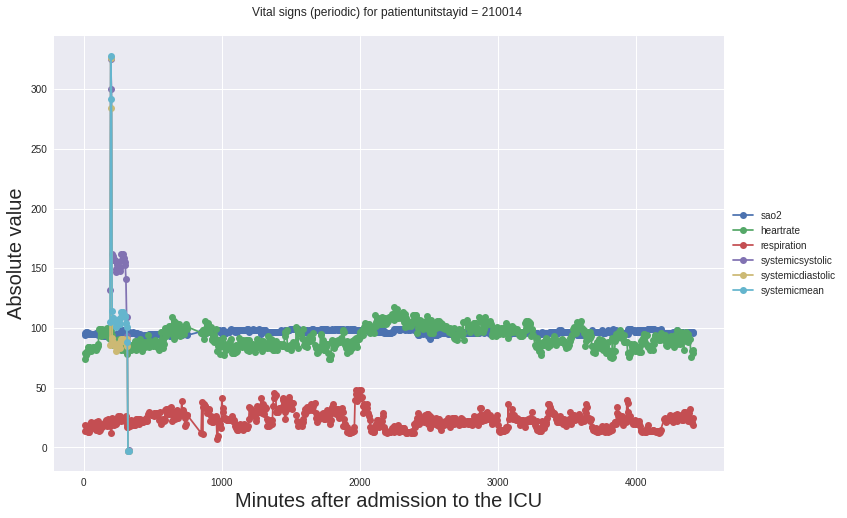

In [75]:
# plot the data
plt.rcParams['figure.figsize'] = [12,8]

title = 'Vital signs (periodic) for patientunitstayid = {} \n'.format(patientunitstayid)
ax = vitalperiodic.plot(title=title, marker='o')

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel("Minutes after admission to the ICU")
ax.set_ylabel("Absolute value")

## Questions

- Which variables are available for this patient?
- What is the peak heart rate during the period?

### The vitalaperiodic table

The vitalAperiodic table provides invasive vital sign data that is recorded at irregular intervals. See: http://eicu-crd.mit.edu/eicutables/vitalAperiodic/


In [0]:
# Get aperiodic vital signs
%%bigquery vitalaperiodic

SELECT *
FROM `physionet-data.eicu_crd_demo.vitalaperiodic`
WHERE patientunitstayid =  210014

In [77]:
# display the first few rows of the dataframe
vitalaperiodic.head()

,vitalaperiodicid,patientunitstayid,observationoffset,noninvasivesystolic,noninvasivediastolic,noninvasivemean,paop,cardiacoutput,cardiacinput,svr,svri,pvr,pvri
0,2389995,210014,2204,93,52,64,None,None,None,None,None,None,None
1,2389979,210014,1539,102,61,76,None,None,None,None,None,None,None
2,2389973,210014,1334,111,61,79,None,None,None,None,None,None,None
3,2389958,210014,889,120,60,80,None,None,None,None,None,None,None
4,2389998,210014,2384,127,56,81,None,None,None,None,None,None,None


In [78]:
# sort the values by the observationoffset (time in minutes from ICU admission)
vitalaperiodic = vitalaperiodic.sort_values(by='observationoffset')
vitalaperiodic.head()

,vitalaperiodicid,patientunitstayid,observationoffset,noninvasivesystolic,noninvasivediastolic,noninvasivemean,paop,cardiacoutput,cardiacinput,svr,svri,pvr,pvri
102,2389927,210014,6,184,111,141,None,None,None,None,None,None,None
99,2389928,210014,14,176,106,134,None,None,None,None,None,None,None
96,2389929,210014,29,167,106,129,None,None,None,None,None,None,None
107,2389930,210014,45,197,117,147,None,None,None,None,None,None,None
100,2389931,210014,47,178,107,137,None,None,None,None,None,None,None


In [79]:
# subselect the variable columns
columns = ['observationoffset','noninvasivesystolic','noninvasivediastolic',
          'noninvasivemean','paop','cardiacoutput','cardiacinput','svr',
          'svri','pvr','pvri']

vitalaperiodic = vitalaperiodic[columns].set_index('observationoffset')
vitalaperiodic.head()

,noninvasivesystolic,noninvasivediastolic,noninvasivemean,paop,cardiacoutput,cardiacinput,svr,svri,pvr,pvri
observationoffset,,,,,,,,,,
6,184,111,141,None,None,None,None,None,None,None
14,176,106,134,None,None,None,None,None,None,None
29,167,106,129,None,None,None,None,None,None,None
45,197,117,147,None,None,None,None,None,None,None
47,178,107,137,None,None,None,None,None,None,None


Text(0, 0.5, 'Absolute value')

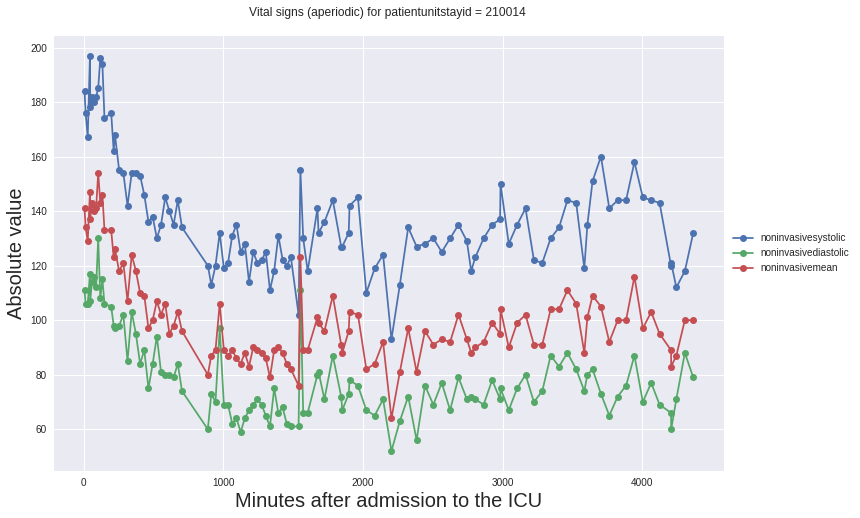

In [92]:
# plot the data
plt.rcParams['figure.figsize'] = [12,8]
title = 'Vital signs (aperiodic) for patientunitstayid = {} \n'.format(patientunitstayid)
ax = vitalaperiodic.plot(title=title, marker='o')

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel("Minutes after admission to the ICU")
ax.set_ylabel("Absolute value")

## Questions

- What do the non-invasive variables measure?
- How do you think the mean is calculated?

## 3.4. The lab table

In [0]:
# Get labs
%%bigquery lab

SELECT *
FROM `physionet-data.eicu_crd_demo.lab`
WHERE patientunitstayid =  210014

In [82]:
lab.head()

,labid,patientunitstayid,labresultoffset,labtypeid,labname,labresult,labresulttext,labmeasurenamesystem,labmeasurenameinterface,labresultrevisedoffset
0,51663768,210014,1174,3,-eos,0.0,0,%,%,1212
1,51227579,210014,-8756,3,-basos,0.0,0,%,%,-8711
2,51057397,210014,4024,3,-basos,0.0,0,%,%,4113
3,55479877,210014,-3470,3,-basos,0.0,0,%,%,-3450
4,51663765,210014,1174,3,-basos,0.0,0,%,%,1212


In [83]:
# sort the values by the offset time (time in minutes from ICU admission)
lab = lab.sort_values(by='labresultoffset')
lab.head()

,labid,patientunitstayid,labresultoffset,labtypeid,labname,labresult,labresulttext,labmeasurenamesystem,labmeasurenameinterface,labresultrevisedoffset
129,57756605,210014,-9226,4,urinary specific gravity,1.021,1.021,,,-9169
96,51227584,210014,-8756,3,Hgb,13.800,13.8,g/dL,g/dL,-8711
90,51909118,210014,-8756,3,PT,11.900,11.9,sec,sec,-8701
47,51909119,210014,-8756,3,PT - INR,1.100,1.1,ratio,,-8701
30,51227577,210014,-8756,3,-lymphs,22.000,22,%,%,-8711


In [84]:
lab = lab.set_index('labresultoffset')
columns = ['labname','labresult','labmeasurenamesystem']
lab = lab[columns]
lab.head()

,labname,labresult,labmeasurenamesystem
labresultoffset,,,
-9226,urinary specific gravity,1.021,
-8756,Hgb,13.800,g/dL
-8756,PT,11.900,sec
-8756,PT - INR,1.100,ratio
-8756,-lymphs,22.000,%


In [85]:
# list the distinct labnames
lab['labname'].unique()

array(['urinary specific gravity', 'Hgb', 'PT', 'PT - INR', '-lymphs',
       'bicarbonate', 'anion gap', 'creatinine', 'chloride', 'MCH', 'BUN',
       'calcium', 'MCHC', 'RDW', 'Hct', 'RBC', 'potassium', '-basos',
       'platelets x 1000', 'MCV', '-eos', 'sodium', '-polys', 'glucose',
       '-monos', 'WBC x 1000', 'CPK', 'bedside glucose', 'paCO2', 'paO2',
       'FiO2', 'HCO3', 'Base Excess', 'pH', 'LPM O2', 'lactate', 'PTT'],
      dtype=object)

In [86]:
# pivot the lab table to put variables into columns
lab = lab.pivot(columns='labname', values='labresult')
lab.head()

labname,-basos,-eos,-lymphs,-monos,-polys,BUN,Base Excess,CPK,FiO2,HCO3,...,creatinine,glucose,lactate,pH,paCO2,paO2,platelets x 1000,potassium,sodium,urinary specific gravity
labresultoffset,,,,,,,,,,,,,,,,,,,,,
-9226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.021
-8756,0.0,3.0,22.0,9.0,66.0,16.0,NaN,NaN,NaN,NaN,...,0.97,131.0,NaN,NaN,NaN,NaN,286.0,3.6,140.0,NaN
-3470,0.0,1.0,12.0,11.0,76.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,370.0,NaN,NaN,NaN
-2526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.024
-36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
# plot laboratory tests of interest
labs_to_plot = ['creatinine','pH','BUN', 'glucose', 'potassium']
lab[labs_to_plot].head()

labname,creatinine,pH,BUN,glucose,potassium
labresultoffset,,,,,
-9226,NaN,NaN,NaN,NaN,NaN
-8756,0.97,NaN,16.0,131.0,3.6
-3470,NaN,NaN,NaN,NaN,NaN
-2526,NaN,NaN,NaN,NaN,NaN
-36,NaN,NaN,NaN,NaN,NaN


Text(0, 0.5, 'Absolute value')

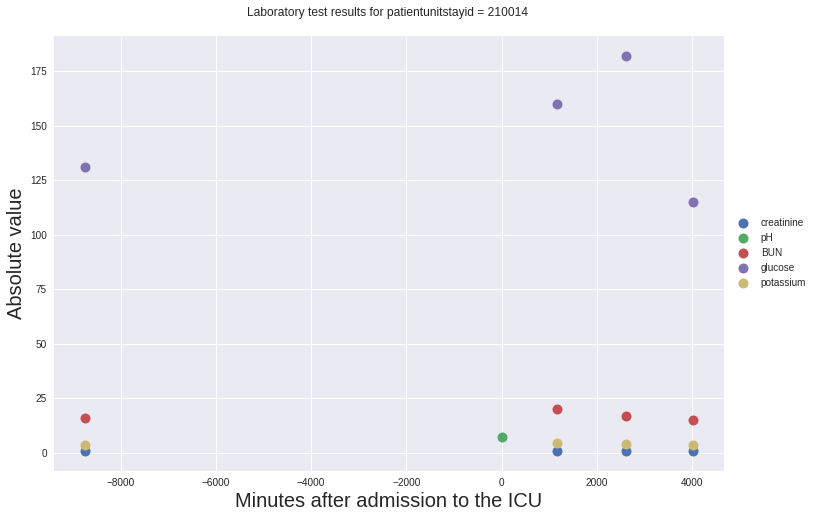

In [90]:
# plot the data
plt.rcParams['figure.figsize'] = [12,8]
title = 'Laboratory test results for patientunitstayid = {} \n'.format(patientunitstayid)
ax = lab[labs_to_plot].plot(title=title, marker='o',ms=10, lw=0)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel("Minutes after admission to the ICU")
ax.set_ylabel("Absolute value")